In [123]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import numpy as np
from io import BytesIO
from PIL import Image
import base64
import json
import PIL.Image
from torchvision import models, transforms
from tensorflow.keras.models import load_model
from scipy.ndimage import zoom
import torch
from skimage.transform import resize
import cv2
import requests

In [122]:
# Load the model from the .h5 file
model = load_model('model_with_background.h5')

In [248]:
def crop_image(image, new_shape):
    current_shape = image.shape
    y_start = (current_shape[0] - new_shape[0]) // 2
    y_end = y_start + new_shape[0]
    x_start = (current_shape[1] - new_shape[1]) // 2
    x_end = x_start + new_shape[1]
    cropped_image = image[y_start:y_end, x_start:x_end, :]
    return cropped_image

def convert_tattoo_to_rgba(image_array, alpha=255):
    # Check if the input image is already in RGBA format
    if image_array.shape[2] == 4:
        return image_array

    # Create an alpha channel with the specified value
    alpha_channel = np.full((image_array.shape[0], image_array.shape[1], 1), alpha, dtype=np.uint8)

    # Identify white pixels
    white_pixels = np.all(image_array == [1., 1., 1.], axis=-1)
    black_pixels = np.all(image_array == [0., 0., 0.], axis=-1)

    # Set alpha to 0 for white pixels
    alpha_channel[white_pixels] = 0
    alpha_channel[black_pixels] = int(0.8 * alpha)

    # Concatenate the alpha channel with the RGB image
    rgba_array = np.concatenate((image_array, alpha_channel), axis=2)

    return rgba_array

def convert_tattoo_to_rgba(image_array, alpha=255):
    # Check if the image is grayscale or RGB. If grayscale, convert it to RGB
    if image_array.shape[2] == 1:
        image_array = np.concatenate((image_array, image_array, image_array), axis=-1)
    
    # If the image is already in RGBA format, no need to convert
    if image_array.shape[2] == 4:
        return image_array

    # Compute the luma component of the image, normalized to be within [0, 1]
    luma = (0.299*image_array[:,:,0] + 0.587*image_array[:,:,1] + 0.114*image_array[:,:,2]) / 255.0

    # Compute the alpha values: lighter pixels will have lower alpha values
    alpha_values = (1.0 - luma) * alpha

    # Make sure alpha values are integers as expected by the RGBA format
    alpha_channel = alpha_values.astype(np.uint8).reshape(image_array.shape[0], image_array.shape[1], 1)

    # Concatenate the alpha channel with the RGB image
    rgba_array = np.concatenate((image_array, alpha_channel), axis=2)

    return rgba_array



def overlay_images(background, overlay):
    # Create a copy of the background image to modify
    result = background.copy()

    # Resize the overlay image to match the background shape
    overlay_resized = overlay[:background.shape[0], :background.shape[1]]

    # Normalize the alpha values to range between 0 and 1
    overlay_alpha = overlay_resized[..., 3] / 255.0

    # Compute the weighted overlay using alpha blending
    result_alpha = 1 - (1 - overlay_alpha) * (1 - result[..., 3] / 255.0)
    result_alpha = np.clip(result_alpha, 0, 1)

    result[..., :3] = overlay_alpha[..., None] * overlay_resized[..., :3] + (1 - overlay_alpha[..., None]) * result[..., :3]
    result[..., 3] = result_alpha * 255

    return result

def invert_colors(image):
    max_value = np.max(image)
    inverted_image = max_value - image
    return inverted_image

def invert_colors(image):
    inverted_image = 255 - image
    return inverted_image

def load_image(final_img):
    img_array = np.array(final_img)
    img = Image.fromarray(img_array)
    with BytesIO() as buffer:
        img.save(buffer, format="PNG")
        png_data = buffer.getvalue()
    # Encode the PNG image data as a base64 string
    base64_str = base64.b64encode(png_data).decode('utf-8')
    # Encode the base64 string as a JSON object
    return json.dumps({"img": base64_str})

In [193]:
novaX = 46
novaY = 165
novaHeight = 90
novaWidth = 90

img = PIL.Image.open('../test_arm.jpg').convert('RGB')
tattoo_image = PIL.Image.open('C:\\Users\\lachl\\inkwell-ai\\client\\src\\images\\tattoos\\flowersTattoo.jpg').convert('RGBA')

In [249]:
img_np = np.array(img)

new_height = 1280
new_width = int(img_np.shape[1] / (img_np.shape[0] / new_height))
resized_image = cv2.resize(img_np, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
cropped_image = crop_image(resized_image, (1280, 720, 3))

# Resize the image using the resize function
resized_pre_image = resize(cropped_image, (160, 90, 3), mode='constant')

# Preprocessing Completed
## Predict keypoint
from IPython.display import Image

# add an extra dimension for the batch
image_batch = np.expand_dims(resized_pre_image, axis=0)

# Make predictions
predictions = model.predict(image_batch)
# Reshape the predicted keypoints array to a (4, 2) matrix
predicted_keypoints = np.array(predictions).reshape((4, 2))

# Read Tattoo Image
from PIL import Image

scaled_tattoo = tattoo_image.resize((int(novaWidth), int(novaHeight)))

# Create a white background image to represent the arm
background_color = (255, 255, 255)  # White color in RGB
background_image = Image.new("RGB", (180, 320), background_color)

# Overlay the image onto the canvas using PIL
background_image.paste(scaled_tattoo, (novaX, novaY))

# Convert the final image to a NumPy array
image_array = np.array(background_image)

1/1 [==============================] - 2s 2s/step


In [241]:
def overlay_images(background, overlay):
    # Create a copy of the background image to modify
    result = background.copy()

    # Resize the overlay image to match the background shape
    overlay_resized = overlay[:background.shape[0], :background.shape[1]]

    # Normalize the alpha values to range between 0 and 1
    overlay_alpha = overlay_resized[..., 3] / 255.0

    # Compute the weighted overlay using alpha blending
    result_alpha = overlay_alpha + (1 - overlay_alpha) * (result[..., 3] / 255.0)
    result_alpha = np.clip(result_alpha, 0, 1)

    result[..., :3] = (overlay_alpha[..., None] * overlay_resized[..., :3] + (1 - overlay_alpha[..., None]) * result[..., :3]) / result_alpha[..., None]
    result[..., 3] = result_alpha * 255

    return result

In [250]:
# changing it to cv2
resized_image = resize(image_array, (320, 180, 3), mode='constant')
## Warp Tattoo Image

unnormalized_image = (resized_image * 255).astype(np.uint8)

# Define the threshold value
threshold = 0.5

# Binarize the image array
binarized_image_array = invert_colors(unnormalized_image)

# making the keypoints for the flat arm
tl = (71, 137)
bl = (63, 320)
tr = (108, 137)
br = (121, 320)

pts1 = np.float32([tl, bl, tr, br])
pts2 = np.float32([[predicted_keypoints[0][0], predicted_keypoints[0][1]], [predicted_keypoints[3][0], predicted_keypoints[3][1]], [predicted_keypoints[1][0], predicted_keypoints[1][1]], [predicted_keypoints[2][0], predicted_keypoints[2][1]]])

matrix = cv2.getPerspectiveTransform(pts1, pts2)
transformed_frame = cv2.warpPerspective(binarized_image_array, matrix, (720, 1280))

# Create the mask
mask = np.zeros((1280, 720), dtype=np.uint8)

# Define the keypoints as a polygon
# tl, tr, bl, br
keypoints = np.float32([[predicted_keypoints[0][0], predicted_keypoints[0][1]],
                        [predicted_keypoints[1][0], predicted_keypoints[1][1]],
                        [predicted_keypoints[2][0], predicted_keypoints[2][1]],
                        [predicted_keypoints[3][0], predicted_keypoints[3][1]]])

cv2.fillPoly(mask, [keypoints.astype(np.int32)], 255)

# Apply the mask to the transformed frame
masked_transformed_frame = cv2.bitwise_and(transformed_frame, transformed_frame, mask=mask)

# Binarize the image array
old_one = np.where(masked_transformed_frame > threshold, 0., 1.) ##invert colours

new_one = invert_colors(masked_transformed_frame)

old_image_with_alpha = convert_tattoo_to_rgba(old_one)

normalized_image = new_one / 255.0

new_image_with_alpha = convert_tattoo_to_rgba(normalized_image)

rgba_arm = convert_tattoo_to_rgba(cropped_image)

overlaid_image = overlay_images(rgba_arm, new_image_with_alpha)

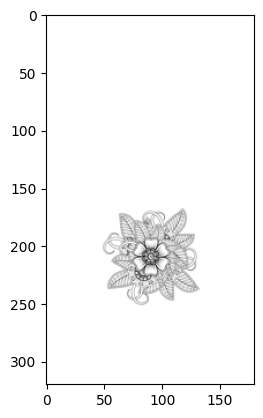

In [243]:
plt.imshow(resized_image)
plt.show()

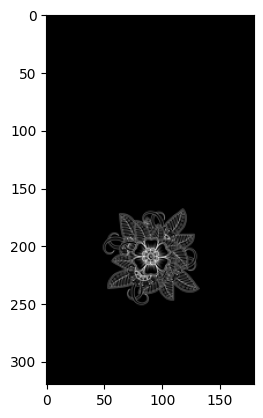

In [244]:
plt.imshow(binarized_image_array_normalized)
plt.show()

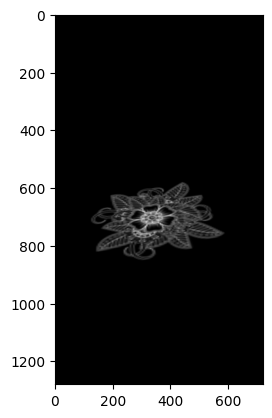

In [245]:
plt.imshow(transformed_frame)
plt.show()

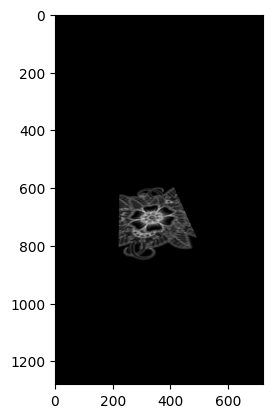

In [246]:
plt.imshow(masked_transformed_frame)
plt.show()

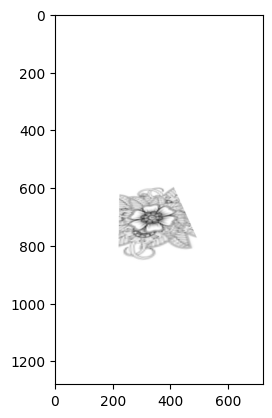

In [227]:
import matplotlib.pyplot as plt
# Display the image and predicted keypoints
plt.imshow(normalized_image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


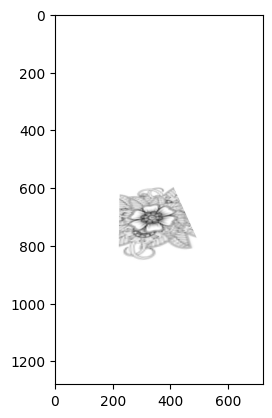

In [235]:
import matplotlib.pyplot as plt
# Display the image and predicted keypoints
plt.imshow(new_image_with_alpha)
plt.show()

In [233]:
print(old_image_with_alpha)

[[[1. 1. 1. 0.]
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]
  ...
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]]

 [[1. 1. 1. 0.]
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]
  ...
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]]

 [[1. 1. 1. 0.]
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]
  ...
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]]

 ...

 [[1. 1. 1. 0.]
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]
  ...
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]]

 [[1. 1. 1. 0.]
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]
  ...
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]]

 [[1. 1. 1. 0.]
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]
  ...
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]
  [1. 1. 1. 0.]]]


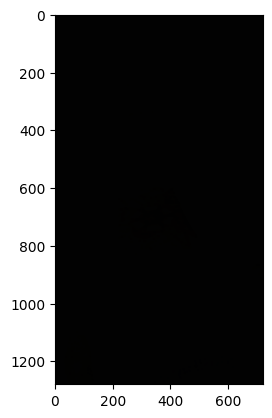

In [251]:
import matplotlib.pyplot as plt
# Display the image and predicted keypoints
plt.imshow(overlaid_image)
plt.show()